In [34]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.chdir("gdrive/My Drive/fashion-mnist")

In [3]:
!pip3 install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [4]:
import torch
a = torch.Tensor([1]).cuda()
print(a)

tensor([1.], device='cuda:0')


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [26]:
# Define the architectures

class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Linear(128 * 3 * 3, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(256, 10)
    )
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

# Define the ResNet architecture
class ResNetClassifier(nn.Module):
    def __init__(self):
        super(ResNetClassifier, self).__init__()
        self.resnet = torchvision.models.resnet18(pretrained=True)
        # Modify the first convolutional layer to accept one input channel instead of three
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Modify the final fully connected layer to output 10 classes instead of 1000
        self.resnet.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.resnet(x)
        return x

# Define a custom CNN architecture
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [33]:
# Define a function to count the number of parameters in a model
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Define a function to train the classifier
def train_classifier(train_loader, classifier, criterion, optimizer):
  classifier.train()
  losses = []
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = classifier(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

  return np.mean(losses)

# Define a function to evaluate the classifier and calculate accuracy
def evaluate_classifier(test_loader, classifier, criterion):
    classifier.eval()
    losses = []
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = classifier(images)
          loss = criterion(outputs, labels)
          losses.append(loss.item())
          _, preds = torch.max(outputs, 1)
          all_labels.extend(labels.cpu().numpy())
          all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return np.mean(losses), accuracy

In [24]:
# Load Fashion-MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [19]:
# Initialize models, criterion, and optimizer
simple_cnn = SimpleCNN()
resnet_classifier = ResNetClassifier()
custom_cnn = CustomCNN()
criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(simple_cnn.parameters(), lr=0.001)
optimizer_resnet = optim.Adam(resnet_classifier.parameters(), lr=0.001)
optimizer_custom = optim.Adam(custom_cnn.parameters(), lr=0.001)

# Train and evaluate Simple CNN
epochs = 5
train_losses_cnn = []
test_losses_cnn = []
accuracies_cnn = []

for epoch in range(epochs):
  train_loss_cnn = train_classifier(train_loader, simple_cnn, criterion, optimizer_cnn)
  test_loss_cnn, accuracy_cnn = evaluate_classifier(test_loader, simple_cnn, criterion)
  train_losses_cnn.append(train_loss_cnn)
  test_losses_cnn.append(test_loss_cnn)
  accuracies_cnn.append(accuracy_cnn)

# Print accuracy and parameters for Simple CNN
print("Simple CNN:")
print("Accuracy:", accuracies_cnn[-1])
print("Number of Parameters:", count_parameters(simple_cnn))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Simple CNN:
Accuracy: 0.9108
Number of Parameters: 390410


In [20]:
# Train and evaluate ResNet
epochs = 5
train_losses_resnet = []
test_losses_resnet = []
accuracies_resnet = []

for epoch in range(epochs):
  train_loss_resnet = train_classifier(train_loader, resnet_classifier, criterion, optimizer_resnet)
  test_loss_resnet, accuracy_resnet = evaluate_classifier(test_loader, resnet_classifier, criterion)
  train_losses_resnet.append(train_loss_resnet)
  test_losses_resnet.append(test_loss_resnet)
  accuracies_resnet.append(accuracy_resnet)

# Print accuracy and parameters for ResNet
print("ResNet:")
print("Accuracy:", accuracies_resnet[-1])
print("Number of Parameters:", count_parameters(resnet_classifier))

ResNey:
Accuracy: 0.8988
Number of Parameters: 11175370


In [28]:
# Train and evaluate Custom CNN
train_losses_custom = []
test_losses_custom = []
accuracies_custom = []
custom_cnn = CustomCNN()
for epoch in range(epochs):
    train_loss_custom = train_classifier(train_loader, custom_cnn, criterion, optimizer_custom)
    test_loss_custom, accuracy_custom = evaluate_classifier(test_loader, custom_cnn, criterion)
    train_losses_custom.append(train_loss_custom)
    test_losses_custom.append(test_loss_custom)
    accuracies_custom.append(accuracy_custom)

# Print accuracy and parameters for Custom CNN
print("Custom CNN:")
print("Accuracy:", accuracies_custom[-1])
print("Number of Parameters:", count_parameters(custom_cnn))

Custom CNN:
Accuracy: 0.1
Number of Parameters: 390410


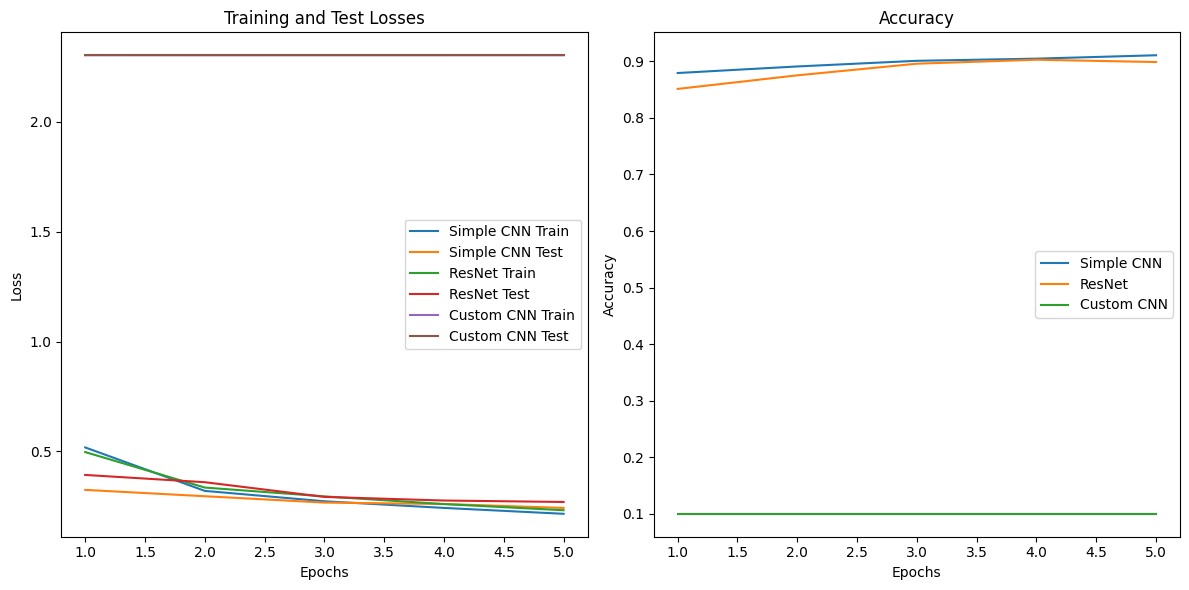

In [29]:
# Plot training and test losses for all architectures
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses_cnn, label='Simple CNN Train')
plt.plot(range(1, epochs + 1), test_losses_cnn, label='Simple CNN Test')
plt.plot(range(1, epochs + 1), train_losses_resnet, label='ResNet Train')
plt.plot(range(1, epochs + 1), test_losses_resnet, label='ResNet Test')
plt.plot(range(1, epochs + 1), train_losses_custom, label='Custom CNN Train')
plt.plot(range(1, epochs + 1), test_losses_custom, label='Custom CNN Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

# Plot accuracies for all architectures
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), accuracies_cnn, label='Simple CNN')
plt.plot(range(1, epochs + 1), accuracies_resnet, label='ResNet')
plt.plot(range(1, epochs + 1), accuracies_custom, label='Custom CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()